In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Summary

## 🚗 Context & Purpose

This week marks our **first successful OBD-II data capture sessions** using the **ELM327 Wi-Fi adapter** on a test vehicle. Despite delays due to device compatibility and connection stability, we conducted three real-world driving trials to evaluate sensor behavior and develop a foundational pipeline for **predictive vehicle diagnostics**.

The goal: identify sensor trends, clean and unify the datasets, and prepare for modeling that will support **maintenance forecasting** and **driver behavior profiling**.

---

## 📂 Data Collection Overview

| Trial | File        | Rows | Columns | Notes                                                |
| ----- | ----------- | ---- | ------- | ---------------------------------------------------- |
| 1     | `test1.csv` | 188  | 51      | Sparse and noisy data; many sensors >80% missing     |
| 2     | `test2.csv` | 63   | 19      | Low frequency sampling; minor gaps                   |
| 3     | `test3.csv` | 115  | 19      | Cleanest sample but still \~0.07Hz polling frequency |

**⚠ Recorder’s Note:**
The ELM327 adapter queried over 50 PIDs (sensor signals), each requiring \~200ms, limiting full scan frequency to \~0.07Hz. This imposed large gaps and reduced granularity in data continuity.

---

## 🧼 Data Cleaning Pipeline

We executed a **Python-based pipeline in Colab** with the following cleaning and transformation steps:

1. **Loaded & merged datasets** using only overlapping columns.
2. Parsed `timestamp` strings to proper `datetime64[ns]` dtype.
3. Removed fully-missing and low-variance columns.
4. Replaced placeholder noise values like `-22`, `-40`, `255` with `NaN`.
5. Imputed missing values using **mean imputation** for numeric fields.
6. Sorted and indexed time-sequentially for accurate time-based trends.
7. Engineered features:

   * `time_diff` (in seconds) between each reading
   * Scaled all features to \[0, 1] range for visualization

✅ **Final cleaned dataset shape:** `(366, 11 + time_diff)`

---

## 📈 Exploratory Insights

### 📊 Summary Statistics

| Feature             | Mean  | Std Dev | Min  | Max  |
| ------------------- | ----- | ------- | ---- | ---- |
| RPM                 | 0.285 | 0.207   | 0.00 | 1.00 |
| SPEED               | 0.348 | 0.266   | 0.00 | 1.00 |
| ENGINE\_LOAD        | 0.132 | 0.155   | 0.00 | 1.00 |
| INTAKE\_TEMP        | 0.216 | 0.234   | 0.00 | 1.00 |
| COOLANT\_TEMP       | 0.714 | 0.167   | 0.00 | 1.00 |
| LONG\_FUEL\_TRIM\_1 | 0.380 | 0.254   | 0.00 | 1.00 |
| time\_diff (s)      | 31.3  | 372.4   | 0.2  | 6024 |

---

### 🔍 Sensor Trends Over Time

<!-- ![Sensor Trends](attachment\:bb4351bf.png) -->

* **RPM** shows short bursts (acceleration events) separated by idling periods.
* **ENGINE\_LOAD** spikes align closely with RPM increases but remain mostly low.
* Temporal gaps confirm non-uniform sampling (\~minutes between bursts).

---

### 🔗 Correlation Analysis

<!-- ![Correlation Heatmap](attachment\:b36f6ef8.png) -->

* **RPM & SPEED** show strong positive correlation (**0.82**).
* **ENGINE\_LOAD** correlates well with **INTAKE\_PRESSURE** and **THROTTLE\_POS** (\~0.64–0.66).
* **LONG\_FUEL\_TRIM\_1** has **strong negative correlation** with RPM and SPEED (–0.83, –0.85), possibly linked to deceleration and cold-start behavior.

---

### 🌡️ Sensor Distributions

#### Intake Temperature

<!-- ![INTAKE\_TEMP](attachment\:cce90fbc.png) -->

* Bi-modal with peaks at **\~0.1** and **\~0.8** (scaled), likely reflecting transitions from engine off → warmup → optimal temperature range.

#### Coolant Temperature

<!-- ![COOLANT\_TEMP](attachment\:c5c5451c.png) -->

* Dominant peak around **0.7–0.75**, suggesting frequent operation in **normal engine temp (\~87–89°C)**.

---

### ⏳ Gap Analysis

<!-- ![Gap Detection](attachment:42dd85aa.png) -->

* Gaps of up to **6000 seconds** (\~1hr 40m) exist between logs.
* Highlights **need for better buffering or resampling** strategies to enable time-series prediction.

---

## ⚙️ Key Challenges

1. **Sparse Sampling:**

   * \~0.07Hz due to hardware PID scan limitations.
   * Future: prioritize key sensors (e.g., RPM, LOAD, SPEED) to increase frequency.

2. **Missing/Anomalous Data:**

   * Placeholder outliers (e.g., 255 or –40°C) required special handling.
   * High missingness in Trial 1 forced reliance on subset of sensors.

3. **Gap Handling:**

   * Time discontinuities will affect models assuming temporal continuity.
   * Options: interpolate, resample, or segment sessions.


# Data Exploration

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
df1 = pd.read_csv("/content/drive/My Drive/EAT40005/W9/test1.csv")
df2 = pd.read_csv("/content/drive/My Drive/EAT40005/W9/test2.csv")
df3 = pd.read_csv("/content/drive/My Drive/EAT40005/W9/test3.csv")

# Display basic info

# Data 1
print("\nDataset 1 Shape:", df1.shape)
print("\nColumn Examples:", df1.columns[:10])
# Check for missing values summary
missing = df1.isna().mean().sort_values(ascending=False)
print("\nTop Missing Data 1 Columns:")
print(missing[missing > 0].head(10))

# Data 2
print("\nDataset 2 Shape:", df2.shape)
print("\nColumn Examples:", df2.columns[:10])
# Check for missing values summary
missing = df2.isna().mean().sort_values(ascending=False)
print("\nTop Missing Data 2 Columns:")
print(missing[missing > 0].head(10))

# Data 3
print("\nDataset 3 Shape:", df3.shape)
print("\nColumn Examples:", df3.columns[:10])
# Check for missing values summary
missing = df3.isna().mean().sort_values(ascending=False)
print("\nTop Missing Data 3 Columns:")
print(missing[missing > 0].head(10))


Dataset 1 Shape: (188, 51)

Column Examples: Index(['timestamp', 'RPM', 'ENGINE_LOAD', 'ABSOLUTE_LOAD', 'COOLANT_TEMP',
       'INTAKE_TEMP', 'AMBIANT_AIR_TEMP', 'OIL_TEMP', 'TIMING_ADVANCE', 'MAF'],
      dtype='object')

Top Missing Data 1 Columns:
ENGINE_LOAD            0.824468
COOLANT_TEMP           0.824468
ABSOLUTE_LOAD          0.824468
BAROMETRIC_PRESSURE    0.824468
RUN_TIME               0.824468
INTAKE_TEMP            0.824468
AMBIANT_AIR_TEMP       0.824468
OIL_TEMP               0.824468
TIMING_ADVANCE         0.824468
MAF                    0.824468
dtype: float64

Dataset 2 Shape: (63, 19)

Column Examples: Index(['timestamp', 'RPM', 'ENGINE_LOAD', 'ABSOLUTE_LOAD', 'COOLANT_TEMP',
       'INTAKE_TEMP', 'OIL_TEMP', 'INTAKE_PRESSURE', 'BAROMETRIC_PRESSURE',
       'CONTROL_MODULE_VOLTAGE'],
      dtype='object')

Top Missing Data 2 Columns:
O2_B1S1       0.015873
O2_SENSORS    0.015873
SPEED         0.015873
dtype: float64

Dataset 3 Shape: (115, 19)

Column Examples: In

# Data Cleaning

✅ Merged file saved!
✅ Cleaned file saved!


<ipython-input-15-3abf747ac094>:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged[col].fillna(df_merged[col].median(), inplace=True)
<ipython-input-15-3abf747ac094>:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

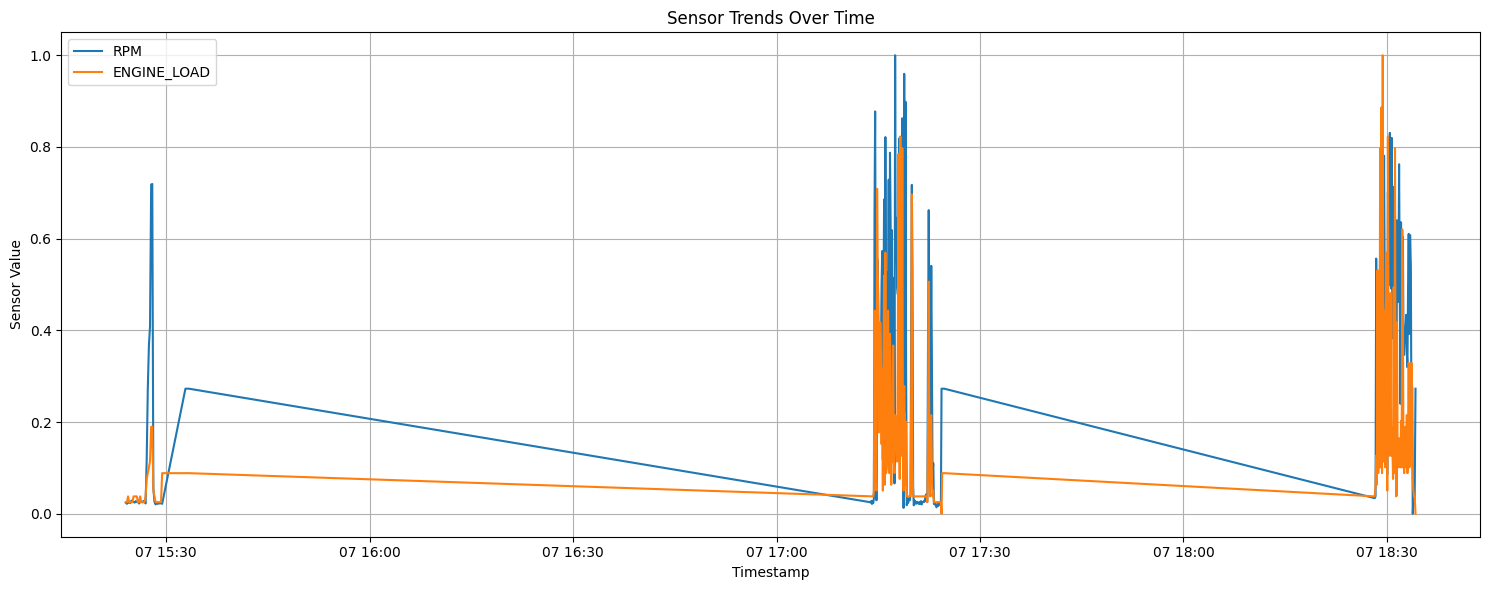

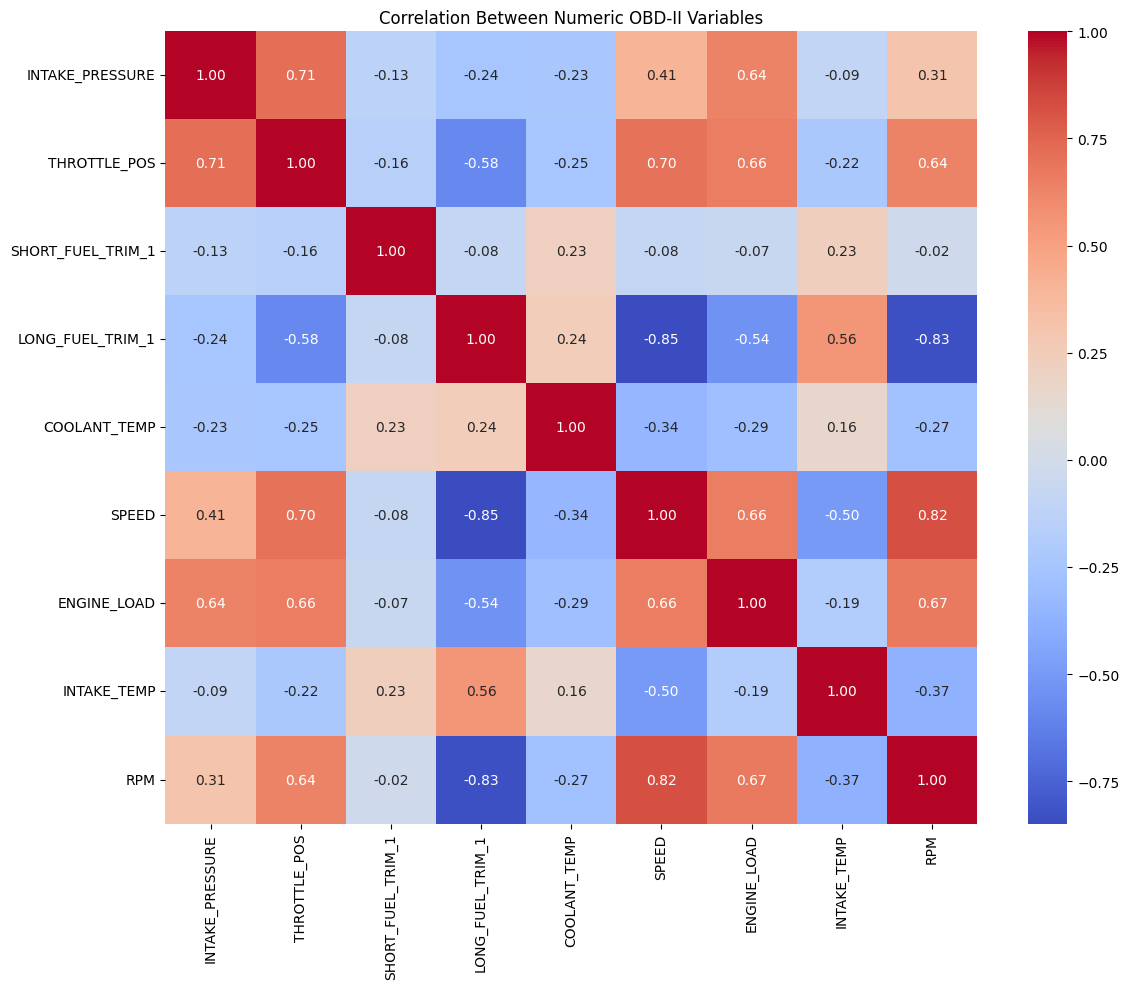

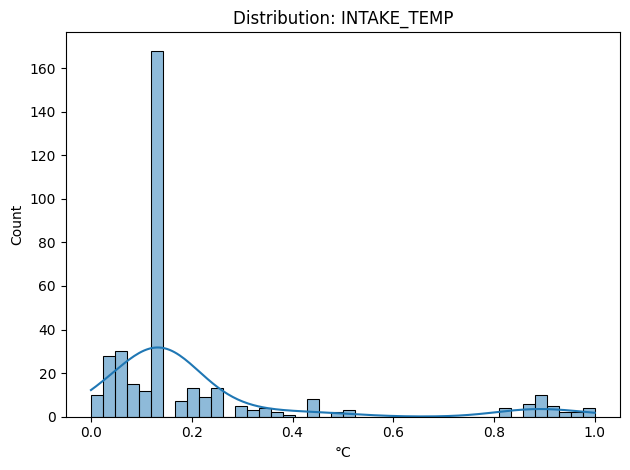

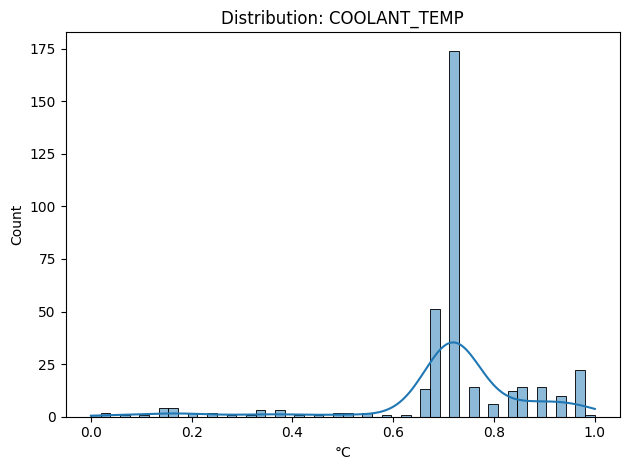

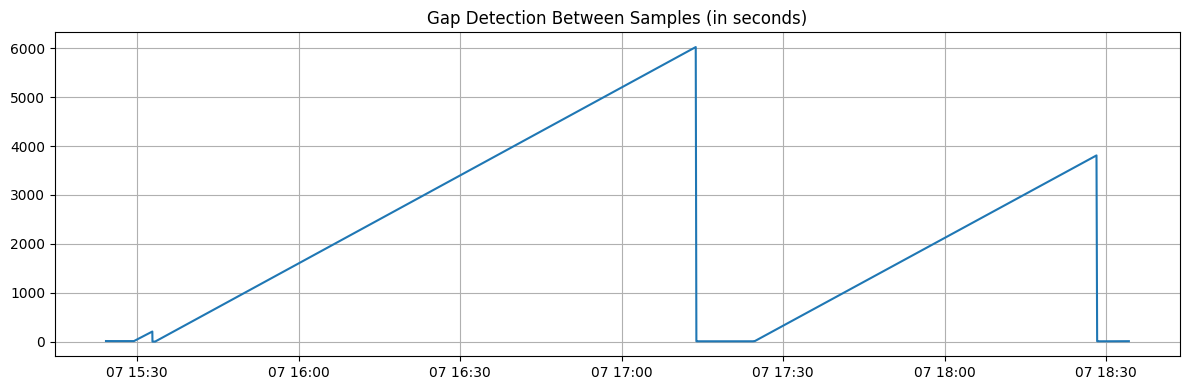


🔍 Summary Statistics of Cleaned Data:
       INTAKE_PRESSURE                      timestamp  THROTTLE_POS  \
count       366.000000                            366    366.000000   
mean          0.135280  2025-05-07 16:36:30.098062848      0.109378   
min           0.000000     2025-05-07 15:24:03.071318      0.000000   
25%           0.075000  2025-05-07 15:33:01.874561536      0.036290   
50%           0.075000  2025-05-07 15:33:20.725289984      0.080645   
75%           0.087500  2025-05-07 17:21:56.105831424      0.096774   
max           1.000000     2025-05-07 18:34:12.509935      1.000000   
std           0.179165                            NaN      0.124250   

       SHORT_FUEL_TRIM_1  LONG_FUEL_TRIM_1  COOLANT_TEMP       SPEED  \
count         366.000000        366.000000    366.000000  366.000000   
mean            0.639123          0.379781      0.714434    0.348133   
min             0.000000          0.000000      0.000000    0.000000   
25%             0.648649         

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# ───────────────────────────────
# 📌 Step 1: Load All Datasets
# ───────────────────────────────
df1 = pd.read_csv('/content/drive/My Drive/EAT40005/W9/test1.csv')
df2 = pd.read_csv('/content/drive/My Drive/EAT40005/W9/test2.csv')
df3 = pd.read_csv('/content/drive/My Drive/EAT40005/W9/test3.csv')

# ──────────────────────────────────────
# 📌 Step 2: Merge on Common Columns Only
# ──────────────────────────────────────
common_cols = list(set(df1.columns) & set(df2.columns) & set(df3.columns))
df_merged = pd.concat([df1[common_cols], df2[common_cols], df3[common_cols]], ignore_index=True)

# Save raw merged file
df_merged.to_csv('/content/drive/My Drive/EAT40005/W9/merged.csv', index=False)
print("✅ Merged file saved!")

# ────────────────────────────────
# 📌 Step 3: Data Cleaning Pipeline
# ────────────────────────────────

# Parse timestamp
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'], errors='coerce')

# Drop empty or constant columns
drop_cols = [col for col in df_merged.columns if df_merged[col].nunique() <= 1 or df_merged[col].isna().all()]
df_merged.drop(columns=drop_cols, inplace=True)

# Drop duplicate columns (identical across rows)
df_merged = df_merged.loc[:, ~df_merged.T.duplicated()]

# Drop exact duplicate rows
df_merged.drop_duplicates(inplace=True)

# Replace placeholder sensor error values
df_merged.replace([-22, -40, 255], np.nan, inplace=True)

# Drop columns with >80% missing
missing_ratio = df_merged.isna().mean()
df_merged.drop(columns=missing_ratio[missing_ratio > 0.8].index, inplace=True)

# Fill missing numeric values with median
for col in df_merged.select_dtypes(include=[np.number]).columns:
    df_merged[col].fillna(df_merged[col].median(), inplace=True)

# Clip extreme RPM outliers (beyond 100 < x < 6000)
if 'RPM' in df_merged.columns:
    df_merged['RPM'] = df_merged['RPM'].apply(lambda x: np.nan if x < 100 or x > 6000 else x)
    df_merged['RPM'].fillna(df_merged['RPM'].median(), inplace=True)

# Final sort and reset
df_cleaned = df_merged.sort_values(by='timestamp').reset_index(drop=True)

# Normalize numeric columns
scaler = MinMaxScaler()
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

# Save cleaned version
df_cleaned.to_csv('/content/drive/My Drive/EAT40005/W9/cleaned.csv', index=False)
print("✅ Cleaned file saved!")

# ────────────────────────────────────
# 📊 Step 4: Feature Engineering (Basic)
# ────────────────────────────────────
if {'ENGINE_LOAD', 'ABSOLUTE_LOAD'}.issubset(df_cleaned.columns):
    df_cleaned['AVG_ENGINE_LOAD'] = df_cleaned[['ENGINE_LOAD', 'ABSOLUTE_LOAD']].mean(axis=1)

if {'INTAKE_TEMP', 'OIL_TEMP', 'COOLANT_TEMP'}.issubset(df_cleaned.columns):
    df_cleaned['TEMP_MEAN'] = df_cleaned[['INTAKE_TEMP', 'OIL_TEMP', 'COOLANT_TEMP']].mean(axis=1)

if {'MAF', 'RPM'}.issubset(df_cleaned.columns):
    df_cleaned['AIRFLOW_PER_RPM'] = df_cleaned['MAF'] / df_cleaned['RPM'].replace(0, np.nan)

# ───────────────────────────────
# 📈 Step 5: Visualization Insights
# ───────────────────────────────

plt.figure(figsize=(15, 6))
for col in ['RPM', 'ENGINE_LOAD', 'ABSOLUTE_LOAD']:
    if col in df_cleaned.columns:
        plt.plot(df_cleaned['timestamp'], df_cleaned[col], label=col)
plt.title("Sensor Trends Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_cleaned.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Numeric OBD-II Variables")
plt.tight_layout()
plt.show()

# Distribution of temperatures
for col in ['INTAKE_TEMP', 'OIL_TEMP', 'COOLANT_TEMP']:
    if col in df_cleaned.columns:
        sns.histplot(df_cleaned[col], kde=True)
        plt.title(f"Distribution: {col}")
        plt.xlabel("\u00b0C")
        plt.tight_layout()
        plt.show()

# Time gap visualization
if 'timestamp' in df_cleaned.columns:
    df_cleaned['time_diff'] = df_cleaned['timestamp'].diff().dt.total_seconds()
    plt.figure(figsize=(12, 4))
    plt.plot(df_cleaned['timestamp'], df_cleaned['time_diff'])
    plt.title("Gap Detection Between Samples (in seconds)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Summary stats
print("\n\U0001F50D Summary Statistics of Cleaned Data:")
print(df_cleaned.describe())

# Next Step?

## **Current Gap: Lack of Labeled Data**

Right now, the OBD-II dataset includes time-series sensor readings (RPM, speed, engine load, etc.) but **lacks labels** that indicate the **operational context or outcomes** like:

* **Driving state**: idle, low-speed cruise, high-speed, braking, accelerating
* **Vehicle identity**: Car A/B/C, Truck A/B/C
* **Maintenance history**: repairs done, time to last service, time to next failure

Without these labels, it's constrained to:

* **Unsupervised learning** (clustering, anomaly detection)
* Or very limited supervised learning on derived/assumed labels

---

## Why Labeled Data Unlocks Value

If we can **label current collected data** (even manually for now), and train models that:

* **Classify driving states** (idle, cruising, accelerating, etc.)
* Predict conditions based on patterns (e.g. rising engine load with same RPM)
* Link sensor patterns to **maintenance outcomes** (if eventually obtained)

Then the model building has:

> **Proof of capability** \
> **Trust in ML pipeline** \
> **A bargaining tool for access to real client data**

This aligns directly with:

* Client’s risk-averse nature (they need proof first)
* Project goal (predictive maintenance)
* Future scalability (applied across fleets, vehicle types, timeframes)

---

## Strategies

1. **Label what we can now**

   * Manually annotate time segments in the data (e.g., "idle", "acceleration", "braking")
   * Use thresholds on RPM/SPEED to auto-segment behaviors (e.g., RPM \~ 700 = idle)

2. **Create a simple classifier**

   * Train a basic ML model (RandomForest/XGBoost) to classify states like "idle" vs "driving"
   * Evaluate performance → show even with small labeled data, it works

3. **Pitch this to the client**

   * Highlight: *"If we can accurately label driving behaviors, imagine the accuracy with real truck data"*
   * It shows the system is **deployable**, not just academic

4. **Plan for label-rich dataset needs**

   * Create a data schema: `Vehicle_ID`, `Timestamp`, `SensorReadings`, `Driving_State`, `Maintenance_Status`

# Visualization

## 📊 Sensor Trend Reflection (Index-Based, No Time Gaps)

The above line plot visualizes multiple OBD-II sensor values collected across three test sessions, plotted against sample index to eliminate misleading gaps caused by irregular timestamp spacing.

### 🔍 Key Observations:

* **Early Flat Regions (Index \~0–180):**

  * Most sensors (RPM, Engine Load, Intake Temp, etc.) remain relatively **static or flat**, suggesting periods of engine idling or no major driving activity.
  * Coolant and intake temperatures are fairly stable, indicating a warmed-up engine or consistent ambient conditions.
* **Middle Section (Index \~180–250):**

  * Sharp **rises in RPM and Engine Load** indicate acceleration or gear shifts.
  * **Intake Pressure and Temperature** also vary accordingly, consistent with dynamic engine activity.
* **Later Segment (Index \~250–370):**

  * Fluctuations increase significantly, with **frequent spikes and dips across all sensors**.
  * This implies a more active driving period with varying speeds, throttle positions, and load conditions.
  * Some short gaps or sudden drops could indicate sensor lag, partial communication loss, or sampling limits.

### ✅ Why Index-Based Plot Is Useful:

* Removes visual distortion from **missing time intervals**, focusing purely on *recorded events*.
* Helps identify **data clusters**, repetition, or redundancy in measurements.
* Ideal for quick comparisons across multiple sensors without being affected by irregular sampling frequency.

### ⚠️ Reflections & Next Steps:

* Some sensors (e.g., **INTAKE\_PRESSURE**) show more erratic behavior, which might warrant further inspection for noise or logging inconsistency.
* Periods of inactivity or sensor constancy may need to be trimmed or downsampled before model training to reduce bias.
* A potential label (e.g., *idle*, *accelerating*, *cruising*) could enhance supervised learning and class interpretation.

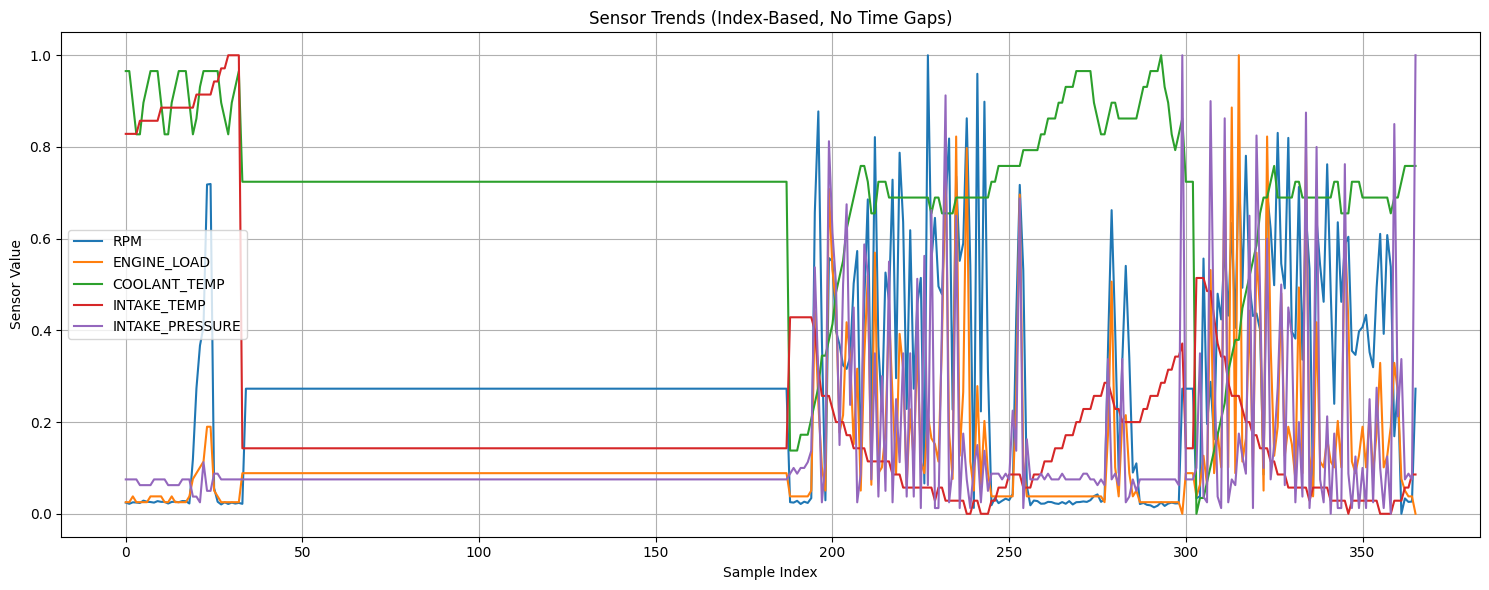

In [17]:
plt.figure(figsize=(15, 6))
for col in ['RPM', 'ENGINE_LOAD', 'ABSOLUTE_LOAD', 'COOLANT_TEMP',
            'INTAKE_TEMP', 'OIL_TEMP', 'INTAKE_PRESSURE', 'BAROMETRIC_PRESSURE',
            'CONTROL_MODULE_VOLTAGE']:
    if col in df_cleaned.columns:
        plt.plot(df_cleaned.index, df_cleaned[col], label=col)

plt.title("Sensor Trends (Index-Based, No Time Gaps)")
plt.xlabel("Sample Index")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()